# Import

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


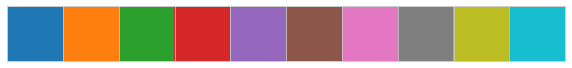

In [0]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns 
import gc
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import train_test_split

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

import os
import datetime

In [0]:
# ! pip install pyLDAvis

ERROR: Operation cancelled by user


In [0]:
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
import pyLDAvis.gensim
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel

ModuleNotFoundError: ignored

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import joblib

In [0]:
PATH = "../content/drive/My Drive/"

# Data

In [0]:
df = pd.read_csv(PATH+'train.csv', index_col = 0)

In [0]:
df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,target
0,Susan BrattonTrusted Hot Sex Advisor To Millio...,1970-01-01 00:00:00.001,Saving Your Marriage By Watching Steamy Sex Ed...,Susan Bratton,medium.com,Lovemaking Sex SexPositions EarlyBird SexEdVideos,5473,http://personallifemedia.com/2017/01/saving-ma...,3,1970,1,0,5,1.09861


In [0]:
df_test = pd.read_csv(PATH+'test.csv', index_col = 0)

In [0]:
df_test.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...,2,2018,2,17,4


# Prepare data

In [0]:
# Большая часть выборки - это данные за 2016 и 2017 год, поэтому обрежем выборку по 2015 год
df = df[df['year']>= 2015]
# Обновим индексы
df = df.reset_index(drop=True)

In [0]:
# Заменим пропущенные на unknown
df['tags'] = df['tags'].fillna('unknown')

In [0]:
# Удалим строки с пропущенными значениями - НЕ БУДЕМ - ЗАМЕНИЛИ 
# df = df[df['tags'] != -1]
# Обновим индексы
# df = df.reset_index(drop=True)

In [0]:
# Удалим дубликаты 
df.drop_duplicates(keep=False, inplace = True)
# Обновим индексы
df = df.reset_index(drop=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57125 entries, 0 to 57124
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   content         57125 non-null  object 
 1   published       57125 non-null  object 
 2   title           57125 non-null  object 
 3   author          57125 non-null  object 
 4   domain          57125 non-null  object 
 5   tags            57125 non-null  object 
 6   length          57125 non-null  int64  
 7   url             57125 non-null  object 
 8   dow             57125 non-null  int64  
 9   year            57125 non-null  int64  
 10  month           57125 non-null  int64  
 11  hour            57125 non-null  int64  
 12  number_of_tags  57125 non-null  int64  
 13  target          57125 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 6.1+ MB


In [0]:
y_train_df = df['target']

In [0]:
# Отметка для последующего разделения датасетов
b = df.shape[0]
# удалим target 
y_train_df = df['target']
# Объединяем test и train датасет для обработки категориальных переменных
df_full = pd.concat([df.drop(columns = 'target'),df_test])
print('df_full shape: ',df_full.shape)

df_full shape:  (91770, 13)


In [0]:
df_full['tags'] = df_full['tags'].fillna('unknown')

In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df_full.columns.tolist(),
              'NaN_count': df_full.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df_full.columns.tolist()).apply(lambda row: df_full[row].nunique()),
              'type': pd.Series(df_full.columns.tolist()).apply(lambda row: df_full[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,91758,object
1,published,0,91596,object
2,title,0,91138,object
3,author,0,42225,object
4,domain,0,231,object
5,tags,0,84618,object
6,length,0,21158,int64
7,url,0,91743,object
8,dow,0,7,int64
9,year,0,4,int64


# LDA "Content"

In [0]:
%%time
train_raw_content = df['content'].values.tolist()
test_raw_content = df_test['content'].values.tolist()

cv = CountVectorizer(max_features=10000, min_df = 0.1, max_df = 0.8)
sparse_train = cv.fit_transform(train_raw_content)
sparse_test  = cv.transform(test_raw_content)

CPU times: user 1min 47s, sys: 1.09 s, total: 1min 48s
Wall time: 1min 48s


In [0]:
%%time
full_sparse_data =  sparse.vstack([sparse_train, sparse_test])

CPU times: user 52.4 ms, sys: 0 ns, total: 52.4 ms
Wall time: 66.2 ms


In [0]:
y_train = df['target'].values

In [0]:
%%time
#Transform our sparse_data to corpus for gensim
corpus_data_gensim = gensim.matutils.Sparse2Corpus(full_sparse_data, documents_columns=False)

CPU times: user 294 µs, sys: 0 ns, total: 294 µs
Wall time: 300 µs


In [0]:
%%time
#Create dictionary for LDA model
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dict = Dictionary()
dict.merge_with(vocabulary_gensim)

CPU times: user 6.81 ms, sys: 0 ns, total: 6.81 ms
Wall time: 6.75 ms


In [0]:
%%time
# Let's assume, that we can devide our articlуs in 30 different topics.
lda = LdaModel(corpus_data_gensim, num_topics = 30)

Streaming output truncated to the last 5000 lines.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Us

CPU times: user 4min 57s, sys: 3min 28s, total: 8min 26s
Wall time: 4min 26s


In [0]:
%%time
# визуализация - не нужна пока 
#data_ =  pyLDAvis.gensim.prepare(lda, corpus_data_gensim, dict)
#pyLDAvis.display(data_)

CPU times: user 4min 10s, sys: 2min 30s, total: 6min 40s
Wall time: 3min 50s


In [0]:
%%time
# Transforms a bag of words document to features. 
# It returns the proportion of how much each topic was present in the document.
def document_to_lda_features(lda_model, document):
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

lda_features = list(map(lambda doc:document_to_lda_features(lda, doc),corpus_data_gensim))

CPU times: user 4min 7s, sys: 2min 59s, total: 7min 7s
Wall time: 3min 38s


In [0]:
%%time
data_pd_lda_features = pd.DataFrame(lda_features)
data_pd_lda_features.head()

CPU times: user 863 ms, sys: 88 ms, total: 951 ms
Wall time: 953 ms


In [0]:
data_pd_lda_features.shape

(91770, 30)

#### Новый признак 'topic'


In [0]:
%%time
# добавим  столбец "topic" - максимум из строк важности топиков (самый важный топик)
data_pd_lda_features['topic'] = data_pd_lda_features.values.argmax(axis=1) 

CPU times: user 21.5 ms, sys: 2.57 ms, total: 24 ms
Wall time: 26.5 ms


In [0]:
data_pd_lda_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,topic
0,0.066086,0.000098,0.000098,0.000098,0.155112,0.000098,0.140351,0.000098,0.022298,0.075483,0.080390,0.000098,0.000098,0.000098,0.000098,0.134760,0.006804,0.021840,0.000098,0.019385,0.000098,0.000098,0.000098,0.000098,0.041354,0.000098,0.000098,0.207695,0.000098,0.026776,27
1,0.056176,0.000059,0.000059,0.000059,0.034039,0.054383,0.077564,0.000059,0.000059,0.000059,0.245394,0.269943,0.000059,0.000059,0.000059,0.033618,0.000059,0.130539,0.000059,0.000059,0.000059,0.000059,0.060690,0.001482,0.014631,0.000059,0.020485,0.000059,0.000059,0.000059,11
2,0.276869,0.000521,0.000521,0.000521,0.000521,0.000521,0.000521,0.000521,0.000521,0.377112,0.072015,0.000521,0.000521,0.000521,0.054363,0.014622,0.000521,0.000521,0.000521,0.000521,0.000521,0.000521,0.000521,0.043887,0.000521,0.000521,0.000521,0.000521,0.000521,0.149153,9
3,0.024819,0.156412,0.106758,0.000149,0.000149,0.000149,0.000149,0.000149,0.000149,0.000149,0.222880,0.153447,0.000149,0.000149,0.000149,0.000149,0.000149,0.063718,0.000149,0.000149,0.076777,0.000149,0.000149,0.087672,0.000149,0.000149,0.000149,0.000149,0.104392,0.000149,10
4,0.000051,0.031744,0.000051,0.000051,0.015044,0.301669,0.121403,0.000051,0.059384,0.000051,0.000051,0.196180,0.000051,0.000051,0.000051,0.000051,0.004431,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.005723,0.059514,0.024592,0.000051,0.000658,0.000051,0.178746,5


# New features

#### Func get_new_features


In [0]:
def get_new_features(df):
  # topic
  #df['topic'] = data_pd_lda_features['topic']
  #df['topic'] = df['topic'].astype('object')
  #print('topic')
  # partofday
  df['partofday'] = df['hour'].map({0: 'night', 1: 'night', 2: 'night',
                                  3: 'night', 4: 'night', 5: 'morning',
                                  6: 'morning', 7: 'morning', 8: 'morning',
                                  9: 'morning', 10: 'morning', 11: 'morning',
                                  12: 'afternoon', 13: 'afternoon', 14: 'afternoon',
                                  15: 'afternoon', 16: 'afternoon', 17: 'afternoon',
                                  18: 'evening', 19: 'evening', 20: 'evening',
                                  21: 'evening', 22: 'evening', 23: 'evening'})
  print('partofday')
  # domain
  def domain_get(label):
    if label == 'medium.com':
      res = 'medium' 
    elif label == 'hackernoon.com':
      res = 'hackernoon'
    else: 
      res = 'others'
    return res 
    
  df['domain_top'] = df['domain'].apply(domain_get)
  print('domain_top')
  # day_type
  def get_day_type(day):
    res = ''
    if day == 5 or day == 6:
      res = 'weekend'
    else: 
      res = 'workday'
    return res
    
  df['day_type'] = df['dow'].apply(get_day_type)
  print('day_type')
  # count_by_author
  df['count_by_author']=df.groupby('author').transform('count')['content']  #count number of posts per author
  print('count_by_author')
  # length_type
  df['length_type']='medium'
  df['length_type'][df.length<800]='short'
  df['length_type'][(df.length>=2500) & (df.length<5000)]='long_read'
  df['length_type'][df.length>=5000]='huge'
  print('length_type')
  # Удалим пробелы из ФИ автора, чтобы работать с сочетаниями Ф+И
  df['author_wo_space'] = df['author'].str.replace(' ', '')
  print('author_wo_space')
  return  df

In [0]:
%%time
df_full = get_new_features(df_full)

partofday
domain_top
day_type
count_by_author
length_type
author_wo_space
CPU times: user 340 ms, sys: 21.4 ms, total: 361 ms
Wall time: 366 ms


#### tags_freq

In [0]:
%%time
cv_tags = CountVectorizer(ngram_range=(1, 1), min_df=5) # ngram_range=(1, 1) - униграмма (последовательность из 1 слова), min_df=5 - не берем слова, частота встречаемости которых меньше 5
tags = cv_tags.fit_transform(df_full.tags.astype('U').values).toarray() 

CPU times: user 1.02 s, sys: 2.04 s, total: 3.06 s
Wall time: 3.06 s


In [0]:
%%time
matrix_freq = tags.sum(axis=0).ravel() # матрица частот тэгов. Ravel() - делает плоский массив (в строку)
tags_freq = np.array([np.array(cv_tags.get_feature_names()), matrix_freq]) # объединяем в 2мерный массив - тэг [0] и его частота [1]

CPU times: user 705 ms, sys: 3.89 ms, total: 709 ms
Wall time: 714 ms


In [0]:
# для аналитики лайков по тэгам 
df_tags = pd.DataFrame()
df_tags['tag'] = tags_freq[0]
df_tags['number_of_posts'] = tags_freq[1]

In [0]:
df_tags['number_of_posts'] = df_tags['number_of_posts'].astype(int)
df_tags['tag'] = df_tags['tag'].astype(str)

In [0]:
def get_num_freq_tags(instr):
  instr = str(instr)
  list_tag = instr.split()
  cnt_freq = 0 
  tmp = []
  # in df_tags нет тэгов, которые встречаются меньше 5 раз 
  for i in list_tag:
      tmp = df_tags[df_tags['tag'] == str.lower(i)]['number_of_posts']
      #print(tmp)
      try:
        tmp_num = int(tmp)
      except: 
        tmp_num = 1 
        
      #print(tmp_num)
      cnt_freq = cnt_freq + tmp_num
      #print(cnt_freq)
  return cnt_freq

In [0]:
%%time
# Применим ко всему датасэту 
df_full['tags_freq'] = df_full['tags'].apply(get_num_freq_tags)

CPU times: user 7min, sys: 810 ms, total: 7min 1s
Wall time: 7min 1s


In [0]:
del cv_tags, tags, matrix_freq, tags_freq

In [0]:
gc.collect()

279

#### Tag Freq log 

In [0]:
df_full['tags_freq_log'] = np.log(df_full['tags_freq'])

#### обработка тэгов тестовой выборки

In [0]:
df_full[df_full['number_of_tags'] == 0]['tags'].unique()

array(['unknown'], dtype=object)

In [0]:
df_full[df_full['number_of_tags'] == 0][['tags', 'tags_freq']]

,tags,tags_freq
0,unknown,2754
1,unknown,2754
2,unknown,2754
3,unknown,2754
4,unknown,2754
...,...,...
34509,unknown,2754
34510,unknown,2754
34512,unknown,2754
34548,unknown,2754


In [0]:
df_full[df_full['number_of_tags'] == 0]['tags_freq'] = 0

In [0]:
df_full[df_full['number_of_tags'] == 0]['tags_freq_log'] =  0

In [0]:
df_full[df_full['tags'] == 'unknown'][['tags', 'tags_freq']]

,tags,tags_freq
0,unknown,2754
1,unknown,2754
2,unknown,2754
3,unknown,2754
4,unknown,2754
...,...,...
34509,unknown,2754
34510,unknown,2754
34512,unknown,2754
34548,unknown,2754


In [0]:
df_full.loc[df_full['tags'] == 'unknown' , 'tags_freq'] = 0
df_full.loc[df_full['tags'] == 'unknown' , 'tags_freq_log'] = 0

# data for model

In [0]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
pd.DataFrame({'Feature': df_full.columns.tolist(),
              'NaN_count': df_full.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df_full.columns.tolist()).apply(lambda row: df_full[row].nunique()),
              'type': pd.Series(df_full.columns.tolist()).apply(lambda row: df_full[row].dtype)})

,Feature,NaN_count,number_of_unique_elements,type
0,content,0,91758,object
1,published,0,91596,object
2,title,0,91138,object
3,author,0,42225,object
4,domain,0,231,object
5,tags,0,84618,object
6,length,0,21158,int64
7,url,0,91743,object
8,dow,0,7,int64
9,year,0,4,int64


In [0]:
df_full.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,topic,partofday,domain_top,day_type,count_by_author,length_type,author_wo_space,tags_freq,tags_freq_log
0,Jason CohenFreelance graveyard content creator...,2015-01-01 00:25:03.904,Sic of Myself,Jason Cohen,medium.com,unknown,5053,https://medium.com/@cohenesque/sic-of-myself-7...,3,2015,1,0,0,27,night,medium,workday,2,huge,JasonCohen,0,0.0


In [0]:
# df.to_csv('df_full.csv')

In [0]:
def data_prepared(data, l_test_data = False, del_label = None): 
#if l_test_data == True:
#   df_model = data[['length_type', 'number_of_tags', 'month', 'hour', 'year', 'dow', 'partofday', 'domain_top', 'tags_freq_log', 'day_type', 'topic', 'count_by_author']] 
# else: 
#   df_model = data[['length_type', 'number_of_tags', 'month', 'hour', 'year',  'dow', 'partofday', 'domain_top', 'tags_freq_log', 'day_type','topic', 'count_by_author', 'target']] 
  
  df_model = data[['length_type', 'number_of_tags', 'month', 'hour', 'year', 'dow', 'partofday', 'domain_top', 'tags_freq_log', 'day_type', 'topic', 'count_by_author']] 
  df_model.reset_index(drop=True, inplace=True)
  if del_label != None: 
    df_model = df_model.drop(columns = del_label)
  # признаки: день недели, месяц, год, час, кол-во тэгов, темы  - сделаем object 
  list_tmp = ['month', 'hour', 'year', 'dow', 'number_of_tags', 'topic']
  for i in list_tmp: 
    df_model[i] = df_model[i].astype(object)
  # категориальные фичи
  cat_features = df_model.columns[df_model.dtypes == 'object'].tolist()
  # числовые признаки
  numerical_feature = df_model.columns[df_model.dtypes != 'object'].tolist()
#  if l_test_data == True:
#    pass 
#  else: 
#    numerical_feature.remove('target')
  # Стандратизация числовых признаков
  scaler=StandardScaler()
  df_scaled = pd.DataFrame(scaler.fit_transform(df_model[numerical_feature]), columns = numerical_feature)
  # Со стандартизированными числовыми признаками новый датасэт  
  df_model = df_model.drop(columns = numerical_feature) # удаляем числовые признаки
  print('ásd1')
  print(df_scaled.shape) 
  print(df_model.shape) 
  df_model = pd.concat([df_scaled, df_model], axis = 1)  # добавляем их уже в стандартизированном формате
  print('ásd2')
  # Обработка категориальных признаков с помощью One Hot Encoding
  df_concat_cat_features = pd.get_dummies(df_model[cat_features])
  print('ásd3')
  # Удаление категориальных переменных
  df_model.drop(cat_features, axis = 1, inplace = True)
  print('ásd4')
  # Присоединение новых
  df_model = pd.concat([df_concat_cat_features, df_model], axis = 1 )
  print('ásd5')
  return df_model

In [0]:
df_model = data_prepared(df_full)

ásd1
(91770, 2)
(91770, 10)
ásd2
ásd3
ásd4
ásd5


In [0]:
df_model.head(1)

,length_type_huge,length_type_long_read,length_type_medium,length_type_short,number_of_tags_0,number_of_tags_1,number_of_tags_2,number_of_tags_3,number_of_tags_4,number_of_tags_5,number_of_tags_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,day_type_weekend,day_type_workday,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,tags_freq_log,count_by_author
0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-3.23016,-0.312979


#### если слетело - загрузка данных 

In [0]:
#df_model.to_csv('df_model.csv')

In [0]:
df_model = pd.read_csv(PATH+'df_model.csv', index_col=0)

In [0]:
df_model.head(1)

,length_type_huge,length_type_long_read,length_type_medium,length_type_short,number_of_tags_0,number_of_tags_1,number_of_tags_2,number_of_tags_3,number_of_tags_4,number_of_tags_5,number_of_tags_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,day_type_weekend,day_type_workday,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,tags_freq_log,count_by_author
0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-3.23016,-0.312979


In [0]:
#df_full.to_csv('df_full.csv')

In [0]:
df_full = pd.read_csv(PATH+'df_full.csv', index_col=0)

In [0]:
df_full.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,partofday,domain_top,day_type,count_by_author,length_type,author_wo_space
0,Jason CohenFreelance graveyard content creator...,2015-01-01 00:25:03.904,Sic of Myself,Jason Cohen,medium.com,unknown,5053,https://medium.com/@cohenesque/sic-of-myself-7...,3,2015,1,0,0,night,medium,workday,2,huge,JasonCohen


In [0]:
#y_train_df.to_csv('y_train_df.csv')

In [0]:
y_train_df = pd.read_csv(PATH+'y_train_df.csv', index_col=0)
y_train_df = y_train_df.values

In [0]:
# Обратное разделение на train и test
b = 57125 
train = df_full[:b]
test_df = df_full[b:]

train_m = df_model[:b]
test_m = df_model[b:]
#y_train_df  = y_train_df.values

In [0]:
train.shape

(57125, 19)

In [0]:
train_m.shape

(57125, 99)

In [0]:
test_df.shape

(34645, 19)

In [0]:
test_m.shape

(34645, 99)

In [0]:
df_model.shape

(91770, 99)

In [0]:
df_full.shape

(91770, 19)

In [0]:
del df_model, df_full

In [0]:
gc.collect()

0

## TF IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Func get_sparce

In [0]:
def get_sparce_labels(data, l_is_test = False): 
  
  cv = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
  if l_is_test:  
    tags_tmp = data['tags'].values.astype('U').tolist()
  else:
    tags_tmp = data['tags'].values.tolist()

  X_train_tags_sparse = cv.fit_transform(tags_tmp) 
  X_train_content_sparse = cv.fit_transform(data['content'].values.tolist())
  X_train_title_sparse = cv.fit_transform(data['title'].values.tolist())

  Cvt=CountVectorizer().fit(df['author_wo_space'].values.tolist())
  X_train_author_sparse = Cvt.transform(df['author_wo_space'].values.tolist())
  X_train_sparse = hstack([X_train_tags_sparse, X_train_content_sparse, 
                           X_train_title_sparse, X_train_author_sparse]).tocsr()
  return X_train_sparse

отдельно для train было. Добавить в такой подход в countvectorizer max_features, чтобы размерности и обучающеей  и  тестовой(с кэггла были  равные)

In [0]:
%%time
cv = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)

CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 38.4 µs


In [0]:
tags_tmp = train['tags'].values.astype('U').tolist()

In [0]:
X_train_tags_sparse = cv.fit_transform(tags_tmp) 

In [0]:
X_train_tags_sparse.shape

(57125, 1000)

In [0]:
%%time
X_train_content_sparse = cv.fit_transform(train['content'].values.tolist())

CPU times: user 4min 21s, sys: 4.61 s, total: 4min 25s
Wall time: 4min 25s


In [0]:
X_train_content_sparse.shape

(57125, 1000)

In [0]:
X_train_title_sparse = cv.fit_transform(train['title'].values.tolist())

In [0]:
X_train_title_sparse.shape

(57125, 1000)

In [0]:
Cvt = CountVectorizer().fit(train['author_wo_space'].values.tolist())

In [0]:
X_train_author_sparse = Cvt.transform(train['author_wo_space'].values.tolist())

In [0]:
X_train_author_sparse.shape

(57125, 30753)

In [0]:
train_m.shape

(57125, 99)

In [0]:
# X_train_sparse[:b]
# del X_train_sparse

In [0]:
X_train_sparse = hstack([X_train_tags_sparse, X_train_content_sparse, 
                           X_train_title_sparse, X_train_author_sparse, train_m]).tocsr()

In [0]:
X_train_sparse

<57125x33852 sparse matrix of type '<class 'numpy.float64'>'
	with 17602275 stored elements in Compressed Sparse Row format>

In [0]:
# сохраним матрицу
#import scipy.sparse
#scipy.sparse.save_npz('X_train_sparse.npz', X_train_sparse)


In [0]:
# загрузка матрицы
X_train_sparse_ = scipy.sparse.load_npz(PATH+'X_train_sparse.npz')

In [0]:
X_train_sparse_[:5]

<5x33852 sparse matrix of type '<class 'numpy.float64'>'
	with 1391 stored elements in Compressed Sparse Row format>

In [0]:
#del X_train, X_holdout, y_train, y_holdout
# y_train_df = df['target'].values
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train_sparse, y_train_df, test_size=0.3,random_state=17)

In [0]:
X_train.shape

(39987, 33852)

In [0]:
del tags_tmp, X_train_tags_sparse, X_train_content_sparse, X_train_title_sparse, X_train_author_sparse
gc.collect()

541

# Models

## Ridge

In [0]:
# в новой версии
%%time
ridge = Ridge(random_state=17)
ridge.fit(X_train,y_train)

CPU times: user 8.64 s, sys: 6.17 s, total: 14.8 s
Wall time: 7.65 s


In [0]:
mean_absolute_error(y_holdout, ridge.predict(X_holdout))

1.0511881373813186

In [0]:
ridge

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=17, solver='auto', tol=0.001)

## Light GBM

In [0]:
# в новой версии 
%%time 
lgbmr = LGBMRegressor(random_state=17)
lgbmr.fit(X_train, y_train)

CPU times: user 1min 42s, sys: 210 ms, total: 1min 42s
Wall time: 53.9 s


In [0]:
mean_absolute_error(y_holdout, lgbmr.predict(X_holdout))

1.1804596980322755

In [0]:
# joblib.dump(lgbmr, "lgbmr.pkl")

['lgbmr.pkl']

In [0]:
lgbmr = joblib.load(PATH+"/models/lgbmr.pkl")

In [0]:
mean_absolute_error(y_holdout, lgbmr.predict(X_holdout))

1.1804596980322755

In [0]:
lgbmr.get_params

<bound method LGBMModel.get_params of LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [0]:
# Var Objective: 

# fair - 1.16
# tweedie - 1.176
# gamma - 1.176
# huber - 1.20

In [0]:
lgbmr = LGBMRegressor(objective = 'fair' , random_state=17)
lgbmr.fit(X_train, y_train)
mean_absolute_error(y_holdout, lgbmr.predict(X_holdout))

1.162811900691968

In [0]:
#joblib.dump(lgbmr, "lgbmr_fair.pkl")

['lgbmr_fair.pkl']

In [0]:
lgbmr = joblib.load(PATH+"/models/lgbmr_fair.pkl")

In [0]:
mean_absolute_error(y_holdout, lgbmr.predict(X_holdout))

1.162811900691968

## XGBoost

In [0]:
%%time 
# В новой версии 
xgbr = xgb.XGBRegressor(random_state=17)
xgbr.fit(X_train, y_train)

[17:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
mean_absolute_error(y_holdout, xgbr.predict(X_holdout))

1.2541195213242415

In [0]:
#joblib.dump(xgbr, "xgbr.pkl")

['xgbr.pkl']

In [0]:
xgbr = joblib.load(PATH+"/models/xgbr.pkl")

[05:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
mean_absolute_error(y_holdout, xgbr.predict(X_holdout))

1.2541195213242415

## Catboost

In [0]:
! pip install catboost

     |████████████████████████████████| 64.7MB 117kB/s 


In [0]:
from catboost import Pool, CatBoostRegressor

In [0]:
# в новой версии 
%%time
catboost = CatBoostRegressor(random_state=17, verbose = 0)
catboost.fit(X_train, y_train)

CPU times: user 23min 42s, sys: 17.4 s, total: 23min 59s
Wall time: 12min 59s


In [0]:
mean_absolute_error(y_holdout, catboost.predict(X_holdout))

1.1464056392357755

In [0]:
mean_absolute_error(y_train, catboost.predict(X_train))

0.9930331514748226

In [0]:
#joblib.dump(catboost, "catboost.pkl")

['catboost.pkl']

In [0]:
catboost = joblib.load(PATH+"/models/catboost.pkl")

In [0]:
mean_absolute_error(y_holdout, catboost.predict(X_holdout))

1.1464056392357755

# Hyper opt 

In [0]:
pip install hyperopt

https://www.kaggle.com/bigironsphere/parameter-tuning-in-one-function-with-hyperopt

In [0]:
#import required packages
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import gc
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample
#optional but advised
import warnings
warnings.filterwarnings('ignore')

#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 100 #number of hyperopt evaluation rounds
N_FOLDS = 3 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**11 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 25 #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'mae' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'auc'#LightGBM classification metric

#XGBOOST PARAMETERS
XGB_MAX_LEAVES = 2**12 #maximum number of leaves when using histogram splitting
XGB_MAX_DEPTH = 25 #maximum tree depth for XGBoost
EVAL_METRIC_XGB_REG = 'mae' #XGBoost regression metric
EVAL_METRIC_XGB_CLASS = 'auc' #XGBoost classification metric

#CATBOOST PARAMETERS
CB_MAX_DEPTH = 8 #maximum tree depth in CatBoost
OBJECTIVE_CB_REG = 'MAE' #CatBoost regression metric
OBJECTIVE_CB_CLASS = 'Logloss' #CatBoost classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0
          

In [0]:
# Сама функция 
def quick_hyperopt(data, labels, package, num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         #'num_leaves',
                         #'max_bin',
                         #'min_data_in_leaf',
                         #'min_data_in_bin'
                         ]
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
            
            best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['RMSE']#['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['fair'] # ['huber', 'gamma', 'fair', 'tweedie']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_reg

        space ={'boosting' : hp.choice('boosting', boosting_list),
                #'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                #'max_bin': hp.quniform('max_bin', 32, 255, 1),
                #'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                #'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                #'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                #'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                #'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                #'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                #'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                #'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                #'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        # ARD best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
          best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['rmse']#['mae', 'rmse'] # ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : -1
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #CatBoost
    #==========
    
    if package=='cb':
        
        print('Running {} rounds of CatBoost parameter optimisation:'.format(num_evals))
        
        #clear memory 
        gc.collect()
            
        integer_params = ['depth',
                          #'one_hot_max_size', #for categorical data
                          'min_data_in_leaf',
                          'max_bin']
        
        def objective(space_params):
                        
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract nested conditional parameters
            if space_params['bootstrap_type']['bootstrap_type'] == 'Bayesian':
                bagging_temp = space_params['bootstrap_type'].get('bagging_temperature')
                space_params['bagging_temperature'] = bagging_temp
                
            if space_params['grow_policy']['grow_policy'] == 'LossGuide':
                max_leaves = space_params['grow_policy'].get('max_leaves')
                space_params['max_leaves'] = int(max_leaves)
                
            space_params['bootstrap_type'] = space_params['bootstrap_type']['bootstrap_type']
            space_params['grow_policy'] = space_params['grow_policy']['grow_policy']
                           
            #random_strength cannot be < 0
            space_params['random_strength'] = max(space_params['random_strength'], 0)
            #fold_len_multiplier cannot be < 1
            space_params['fold_len_multiplier'] = max(space_params['fold_len_multiplier'], 1)
                       
            #for classification set stratified=True
            cv_results = cb.cv(train, space_params, fold_count=N_FOLDS, 
                             early_stopping_rounds=25, stratified=False, partition_random_seed=42)
           
            best_loss = cv_results['test-MAE-mean'].iloc[-1] #'test-RMSE-mean' for RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = cv_results['test-Logloss-mean'].iloc[-1]
            #if necessary, replace 'test-Logloss-mean' with 'test-[your-preferred-metric]-mean'
            
            return{'loss':best_loss, 'status': STATUS_OK}
        
        train = cb.Pool(data, labels.astype('float32'))
        
        #integer and string parameters, used with hp.choice()
        bootstrap_type = [# {'bootstrap_type':'Poisson'}, - ARD: закомментил , тк CPU dont support Poisson
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 
        LEB = ['No', 'AnyImprovement'] #, 'Armijo'] #remove 'Armijo' if not using GPU
        #score_function = ['Correlation', 'L2', 'NewtonCorrelation', 'NewtonL2']
        grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]
        eval_metric_list_reg = ['MAE','RMSE'] #, 'Poisson']
        eval_metric_list_class = ['Logloss', 'AUC', 'F1']
        #for classification change line below to 'eval_metric_list = eval_metric_list_class'
        eval_metric_list = eval_metric_list_reg
                
        space ={'depth': hp.quniform('depth', 2, CB_MAX_DEPTH, 1),
                'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
                'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
                'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
                #'one_hot_max_size' : hp.quniform('one_hot_max_size', 2, 16, 1), #uncomment if using categorical features
                'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
                'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
                #'eval_metric' : hp.choice('eval_metric', eval_metric_list), ARD за комментил
                'objective' : OBJECTIVE_CB_REG,
                #'score_function' : hp.choice('score_function', score_function), #crashes kernel - reason unknown
                'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
                'grow_policy': hp.choice('grow_policy', grow_policy),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only : ARD раскомментил
                'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
                'od_type' : 'Iter',
                'od_wait' : 25,
                #'task_type' : 'GPU', # ARD: закомментил
                'verbose' : 0
            }
        
        #optional: run CatBoost without GPU
        #uncomment line below
        space['task_type'] = 'CPU'
            
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        #unpack nested dicts first
        best['bootstrap_type'] = bootstrap_type[best['bootstrap_type']]['bootstrap_type']
        best['grow_policy'] = grow_policy[best['grow_policy']]['grow_policy']
        best['eval_metric'] = eval_metric_list[best['eval_metric']]
        
        #best['score_function'] = score_function[best['score_function']] 
        best['leaf_estimation_method'] = LEM[best['leaf_estimation_method']] #CPU only
        best['leaf_estimation_backtracking'] = LEB[best['leaf_estimation_backtracking']]        
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    else:
        print('Package not recognised. Please use "lgbm" for LightGBM, "xgb" for XGBoost or "cb" for CatBoost.')    

In [0]:
data = X_train
labels = y_train

## Light GBM

In [0]:
NUM_EVALS = 20
lgbm_params = quick_hyperopt(data, labels, package='lgbm', num_evals= NUM_EVALS, diagnostic=False)

Running 20 rounds of LightGBM parameter optimisation:
100%|██████████| 20/20 [13:51<00:00, 41.58s/it, best loss: 1.2233712478644583]
{boosting: gbdt
max_depth: 6.0
objective: fair
subsample: 0.7184605315849397}


In [0]:
# num_evals = 2 - MAE = 1.19
# num_evals = 10 - MAE = 1.16
# num_evals = 20, max_depth = , 1.17 - MAE =  
%%time
lgbm_params = {'boosting': 'gbdt', 'max_depth': 6, 'objective': 'fair', 'subsample': 0.7184605315849397}
lgbm_ho = lgb.LGBMRegressor(random_state=17, **lgbm_params)
lgbm_ho.fit(X_train, y_train)
mae_train = mean_absolute_error(y_train, lgbm_ho.predict(X_train))
mae_test = mean_absolute_error(y_holdout, lgbm_ho.predict(X_holdout))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(lgbm_params) , index = [0])
res_lgbm = pd.concat([best_df, mae_df], axis = 1)
res_lgbm

CPU times: user 1min 8s, sys: 163 ms, total: 1min 8s
Wall time: 36.2 s


In [0]:
res_lgbm

,boosting,max_depth,objective,subsample,MAE_TRAIN,MAE_TEST
0,gbdt,6,fair,0.718461,1.018965,1.173166


## XGBoost 

In [0]:

xgb_params = quick_hyperopt(data, labels, package='xgb', num_evals=NUM_EVALS, diagnostic=False)

In [0]:
%%time 
xgb_ho = xgb.XGBRegressor(random_state=17, **xgb_params)
xgb_ho.fit(X_train, y_train)
mae_train = mean_absolute_error(y_train, xgb_ho.predict(X_train))
mae_test = mean_absolute_error(y_holdout, xgb_ho.predict(X_holdout))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(xgb_params) , index = [0])
res_xgb = pd.concat([best_df, mae_df], axis = 1)
res_xgb 

[06:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,boosting,colsample_bylevel,colsample_bynode,colsample_bytree,eval_metric,gamma,learning_rate,max_depth,min_child_weight,objective,reg_alpha,reg_lambda,subsample,tree_method,MAE_TRAIN,MAE_TEST
0,gblinear,0.67,0.72,0.73,mae,3.412764,0.179834,16,0.068109,reg:linear,4.291973,1.952514,1.0,exact,0.435651,1.240555


## Catboost

In [0]:
pip install colorama

In [0]:
import sklearn
import catboost
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama

N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

In [0]:
def get_catboost_params(space):
    params = dict()
    params['learning_rate'] = space['learning_rate']
    params['depth'] = int(space['depth'])
    params['l2_leaf_reg'] = space['l2_leaf_reg']
    #params['border_count'] = space['border_count']
    #params['n_estimators'] = space['n_estimators']
    #params['rsm'] = space['rsm']
    
    # Новые параметры 
    #params['max_bin'] = space['max_bin']
    #params['min_data_in_leaf'] = space['min_data_in_leaf']
    #params['random_strength'] = space['random_strength']
    #params['bootstrap_type'] = space['bootstrap_type']
    #params['leaf_estimation_backtracking'] = space['leaf_estimation_backtracking']
    #params['grow_policy'] = space['grow_policy']
    #params['colsample_bylevel'] = space['colsample_bylevel']
    #params['fold_len_multiplier'] = space['fold_len_multiplier']
    #params['od_type'] = space['od_type']
    #params['od_wait'] = space['od_wait']
        
    return params

In [0]:
obj_call_count = 0
#cur_best_loss = np.inf
cur_best_mae = np.inf 

def objective(space):
    global obj_call_count, cur_best_mae #cur_best_loss

    obj_call_count += 1

    #print('\nCatBoost objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count,cur_best_loss) )
    print('\nCatBoost objective call #{} cur_best_mae={:7.5f}'.format(obj_call_count,cur_best_mae) )

    params = get_catboost_params(space)

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    model = catboost.CatBoostRegressor(#iterations=100, # убрать если будем итерироваться по n_estimators 
                                        learning_rate=params['learning_rate'],
                                        depth=int(params['depth']),
                                        #loss_function='Logloss',
                                        #use_best_model=True,
                                        #task_type="GPU",
                                        eval_metric= 'RMSE',
                                        l2_leaf_reg=params['l2_leaf_reg'],
                                        early_stopping_rounds=3000,
                                        od_type="Iter",
                                        random_state = 17,
                                        n_estimators = 10, #int(params['n_estimators']),  #100, - убрать, если по итерациям будем работать
                                        #border_count=int(params['border_count'])
                                        #verbose=False
                                        #max_bin = params['max_bin'],
                                        #min_data_in_leaf = params['min_data_in_leaf'] ,
                                        #random_strength = params['random_strength'] ,
                                        #bootstrap_type = params['bootstrap_type'] ,
                                        #leaf_estimation_backtracking = params['leaf_estimation_backtracking'] ,
                                        #grow_policy = params['grow_policy'] ,
                                        #colsample_bylevel = params['colsample_bylevel'] ,
                                        #fold_len_multiplier = params['fold_len_multiplier'] 
                                        
                                        )
    
    #model.fit(D_train, eval_set=D_test, verbose=False)
    model.fit(X_train,y_train) #, eval_set = D_test)
    nb_trees = model.tree_count_

    print('nb_trees={}'.format(nb_trees))

    #y_pred = model.predict_proba(D_test.get_features())
    y_pred = model.predict(X_holdout)
    #test_loss = sklearn.metrics.log_loss(D_test.get_label(), y_pred, labels=[0, 1])
    test_mae = mean_absolute_error(y_holdout, y_pred)
    #acc = sklearn.metrics.accuracy_score(D_test.get_label(), np.argmax(y_pred, axis=1))
    #auc = sklearn.metrics.roc_auc_score(D_test.get_label(), y_pred[:,1])

    #log_writer.write('loss={:<7.5f} acc={} auc={} Params:{} nb_trees={}\n'.format(test_loss, acc, auc, params_str, nb_trees ))
    #log_writer.flush()

   #if test_loss<cur_best_loss:
       #cur_best_loss = test_loss
       #print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)

    if test_mae<cur_best_mae:
       cur_best_mae = test_mae
       #print(colorama.Fore.GREEN + 'NEW BEST MAE={}'.format(cur_best_mae) + colorama.Fore.RESET)  
    print("cur_best_mae =  "  + str(cur_best_mae)) 
    
    #score = mean_absolute_error(y_train_1k, model.predict(X_train_1k))
    score = -cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error", n_jobs=-1).mean()
    #score = -cross_val_score(model, X_train_ho, y_train_ho, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
    return score

In [0]:
LEB = ['No', 'AnyImprovement']
grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]

bootstrap_type = [# {'bootstrap_type':'Poisson'}, - ARD: закомментил , тк CPU dont support Poisson
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 

space = {
        #'depth': hp.quniform("depth", 1, 9, 1),
        #'border_count': hp.uniform ('border_count', 32, 255),
        #'learning_rate': hp.loguniform('learning_rate', -5.0, -1),
        #'l2_leaf_reg': hp.uniform('l2_leaf_reg', 3, 8),
      
         'depth': hp.quniform('depth', 2, 9, 1),
         #'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
         'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 8),
         #'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
         #'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
         #'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
         'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
         #'objective' : 'MAE',
         #'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
          #'grow_policy': hp.choice('grow_policy', grow_policy),
         # 'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only : ARD раскомментил
         # 'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
          #'od_type' : 'Iter',
          #'od_wait' : 25,
          #'task_type' : 'GPU', # ARD: закомментил
          #'verbose' : 0
        }

trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo= HYPEROPT_ALGO,
                     max_evals= 10, #  N_HYPEROPT_PROBES,
                     trials=trials#, verbose=True
                     )

print('-'*50)
print('The best params:')
print( best )
print('\n\n')


CatBoost objective call #1 cur_best_mae=    inf
Params: depth=2.0 l2_leaf_reg=0.456384497864053 learning_rate=0.1294997495082292
0:	learn: 1.8881516	total: 218ms	remaining: 1.96s

1:	learn: 1.8633878	total: 437ms	remaining: 1.75s

2:	learn: 1.8430633	total: 679ms	remaining: 1.58s

3:	learn: 1.8260312	total: 900ms	remaining: 1.35s

4:	learn: 1.8100486	total: 1.13s	remaining: 1.13s

5:	learn: 1.7967486	total: 1.37s	remaining: 911ms

6:	learn: 1.7833569	total: 1.58s	remaining: 677ms

7:	learn: 1.7730587	total: 1.81s	remaining: 453ms

8:	learn: 1.7630534	total: 2.04s	remaining: 227ms

9:	learn: 1.7549764	total: 2.26s	remaining: 0us

nb_trees=10
cur_best_mae =  1.4651922042033052

CatBoost objective call #2 cur_best_mae=1.46519
Params: depth=8.0 l2_leaf_reg=6.1472434453221325 learning_rate=0.054869524823620175
                                                                            

In [0]:
#best.update({'border_count': int(best['border_count'])})
# 16 мая: n_estim-s = 100 (in hyper score), n_estim-s = 5000 (1.12)
# ИЗменил : n_estim-s = 1000 (in hyper score), n_estim-s = 10 000 (CHECK?)
catboost_hyper = catboost.CatBoostRegressor(#iterations=1000, 
                                    #loss_function='',
                                    #use_best_model=True,
                                    #task_type="GPU",
                                    eval_metric= 'RMSE',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    random_state = 17,
                                    #verbose=2000,
                                    n_estimators = 10000,
                                    **best
                                    )
catboost_hyper.fit(X_train,y_train) #, verbose=2000)


Streaming output truncated to the last 5000 lines.
5001:	learn: 0.2815434	total: 21m 5s	remaining: 21m 4s
5002:	learn: 0.2814864	total: 21m 5s	remaining: 21m 3s
5003:	learn: 0.2814828	total: 21m 5s	remaining: 21m 3s
5004:	learn: 0.2814397	total: 21m 5s	remaining: 21m 3s
5005:	learn: 0.2813888	total: 21m 6s	remaining: 21m 3s
5006:	learn: 0.2812421	total: 21m 6s	remaining: 21m 2s
5007:	learn: 0.2811528	total: 21m 6s	remaining: 21m 2s
5008:	learn: 0.2810648	total: 21m 6s	remaining: 21m 2s
5009:	learn: 0.2809936	total: 21m 7s	remaining: 21m 2s
5010:	learn: 0.2809744	total: 21m 7s	remaining: 21m 1s
5011:	learn: 0.2808760	total: 21m 7s	remaining: 21m 1s
5012:	learn: 0.2807956	total: 21m 7s	remaining: 21m 1s
5013:	learn: 0.2806288	total: 21m 8s	remaining: 21m 1s
5014:	learn: 0.2805410	total: 21m 8s	remaining: 21m
5015:	learn: 0.2803882	total: 21m 8s	remaining: 21m
5016:	learn: 0.2802738	total: 21m 9s	remaining: 21m
5017:	learn: 0.2801901	total: 21m 9s	remaining: 21m
5018:	learn: 0.2801793	tot

In [0]:

mae_train = mean_absolute_error(y_train, catboost_hyper.predict(X_train))
mae_test = mean_absolute_error(y_holdout, catboost_hyper.predict(X_holdout))
mae_df = pd.DataFrame({'MAE_TRAIN': mae_train, 'MAE_TEST': mae_test }, index = [0])
best_df = pd.DataFrame(dict(best) , index = [0])
result_test = pd.concat([best_df, mae_df], axis = 1)
result_test

,depth,l2_leaf_reg,learning_rate,MAE_TRAIN,MAE_TEST
0,8.0,6.655447,0.16376,0.067191,1.117985


In [0]:
%%time
joblib.dump(catboost_hyper, "catboost_hyper_10kNEstims_freq_log.pkl")

CPU times: user 99.2 ms, sys: 69 ms, total: 168 ms
Wall time: 169 ms


['catboost_hyper_10kNEstims_freq_log.pkl']

# Stacking 

In [0]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np

# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
#pd.set_option('display.mpl_style', 'default')
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Vernada' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Vernada', #Droid Sans
        'weight': 'normal'}
rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state= 17):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

In [0]:
# Отрисовка признаковых пространств 
from sklearn.metrics import roc_auc_score, mean_absolute_error

def run_and_plot(clf, X, y, label):
    # plt.figure(figsize=(6, 5))
    
    a = clf.predict(X)
    
    print (label + ' MAE  = ' + str( mean_absolute_error(y, a) ))


In [0]:
%%time
#joblib.dump(lgbm_ho, "lgbm_tag_freq_log.pkl")
#joblib.dump(xgb_ho, "xgb_ho_tag_freq_log.pkl")
#joblib.dump(catboost_hyper, "cb_hyper(v3)_tag_freq_log.pkl")
lgbmr = joblib.load(PATH+"/models/lgbmr_fair.pkl")
xgbr = joblib.load(PATH+"/models/xgbr.pkl")
catboost = joblib.load(PATH+"/models/catboost.pkl")

[06:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 401 ms, sys: 17 ms, total: 418 ms
Wall time: 520 ms


In [0]:
train_X, test_X, train_y, test_y = train_test_split(X_train_sparse, y_train_df, train_size=0.7, random_state=17)

In [0]:
train_y = train_y.reshape(train_y.shape[0],)

In [0]:
train_y

array([2.70805, 7.09091, 4.30407, ..., 4.70953, 1.09861, 6.77765])

In [0]:
test_y = test_y.reshape(test_y.shape[0],)

In [0]:
test_y

array([5.95584, 2.48491, 1.94591, ..., 1.94591, 0.69315, 1.09861])

In [0]:
%%time
rg0 = Ridge(alpha=0.01, random_state=17)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')


ridge-0.01 MAE  = 1.1448927616556437
CPU times: user 18.5 s, sys: 13.2 s, total: 31.7 s
Wall time: 16.2 s


In [0]:
%%time
rg1 = Ridge(alpha = 1, random_state=17)
rg1.fit(train_X, train_y)
run_and_plot(rg1, test_X, test_y, 'ridge-1')


ridge-1 MAE  = 1.0511881373813186
CPU times: user 10.5 s, sys: 7.52 s, total: 18 s
Wall time: 9.22 s


In [0]:
%%time
rg10 = Ridge(alpha = 10, random_state=17)
rg10.fit(train_X, train_y)
run_and_plot(rg10, test_X, test_y, 'ridge-10')

ridge-10 MAE  = 1.1279893125593465
CPU times: user 4.71 s, sys: 3.26 s, total: 7.97 s
Wall time: 4.11 s


In [0]:
%%time
lgbmr = LGBMRegressor(objective = 'fair' , random_state=17)
lgbmr.fit(train_X, train_y)
run_and_plot(lgbmr, test_X, test_y, 'lgbmr')

lgbmr MAE  = 1.162811900691968
CPU times: user 1min 1s, sys: 202 ms, total: 1min 2s
Wall time: 1min 2s


In [0]:
%%time 
xgbr = xgb.XGBRegressor(random_state=17)
xgbr.fit(train_X, train_y)
run_and_plot(xgbr, test_X, test_y, 'xgbr')

[07:11:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgbr MAE  = 1.2541195213242415
CPU times: user 2min 16s, sys: 168 ms, total: 2min 16s
Wall time: 2min 17s


In [0]:
%%time
catboost = CatBoostRegressor(random_state=17, verbose = 0)
catboost.fit(train_X, train_y)
run_and_plot(catboost, test_X, test_y, 'catboost')

catboost MAE  = 1.1464056392357755
CPU times: user 22min 38s, sys: 10.5 s, total: 22min 48s
Wall time: 12min 9s


In [0]:
# Сохраним модели
%%time
joblib.dump(rg0, "rg0.pkl")
joblib.dump(rg1, "rg1.pkl")
joblib.dump(rg10, "rg10.pkl")
joblib.dump(lgbmr, "lgbmr_stack.pkl")
joblib.dump(xgbr, "xgbr_stack.pkl")
joblib.dump(catboost, "catboost_stack.pkl")

CPU times: user 823 ms, sys: 14 ms, total: 837 ms
Wall time: 843 ms


In [0]:
# загрузка моделей 
rg0 = joblib.load(PATH+"/models/rg0.pkl")
rg1 = joblib.load(PATH+"/models/rg1.pkl")
rg10 = joblib.load(PATH+"/models/rg10.pkl")
lgbmr = joblib.load(PATH+"/models/lgbmr_stack.pkl")
xgbr = joblib.load(PATH+"/models/xgbr_stack.pkl")
catboost = joblib.load(PATH+"/models/catboost_stack.pkl")

In [0]:
%%time
# Запускаем блэндинг и стэкинг без лесов 
models = [rg0_tmp, rg1_tmp, rg10, lgbmr, xgbr, catboost] # rf1, rf2, # , rf3 
ens_model = Ridge()
s1 = DjStacking(models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking') # 1ый стэкинг

[07:32:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1-stacking MAE  = 1.0384154146921765
CPU times: user 24min 26s, sys: 1min 40s, total: 26min 7s
Wall time: 15min 2s


In [0]:
joblib.dump(s1, "s1_stacking.pkl")

['s1_stacking.pkl']

In [0]:
%%time
# 2ой стэкинг
s2 = DjStacking(models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s2, test_X, test_y, '2-stacking') 
# >27 min 

[07:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2-stacking MAE  = 1.017343169830916
CPU times: user 26min 39s, sys: 37.1 s, total: 27min 16s
Wall time: 55min 17s


In [0]:
joblib.dump(s2, "s2_stacking.pkl")

['s2_stacking.pkl']

In [0]:
s2 = joblib.load(PATH+"models/s2_stacking.pkl")

[08:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
run_and_plot(s2, test_X, test_y, '2-stacking') 

# Stacking 2

# Result 

## test data preprocessing

In [0]:
test_df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,partofday,domain_top,day_type,count_by_author,length_type,author_wo_space
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...,2,2018,2,17,4,afternoon,medium,workday,3,huge,HITRECORD


In [0]:
test_m.head(1)

,length_type_huge,length_type_long_read,length_type_medium,length_type_short,number_of_tags_0,number_of_tags_1,number_of_tags_2,number_of_tags_3,number_of_tags_4,number_of_tags_5,number_of_tags_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,year_2015,year_2016,year_2017,year_2018,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,partofday_afternoon,partofday_evening,partofday_morning,partofday_night,domain_top_hackernoon,domain_top_medium,domain_top_others,day_type_weekend,day_type_workday,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,tags_freq_log,count_by_author
57125,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.440318,-0.271728


In [0]:
test_df.head(1)

,content,published,title,author,domain,tags,length,url,dow,year,month,hour,number_of_tags,partofday,domain_top,day_type,count_by_author,length_type,author_wo_space
0,Member previewHITRECORDhitrecord.org is a new ...,2018-02-21 17:01:00.928,"For Night Owls, the Day Starts with a Nocturna...",HITRECORD,medium.com,MorningRoutines Hitrecord Podcast Night,12500,https://medium.com/on-mornings/nocturnalmornin...,2,2018,2,17,4,afternoon,medium,workday,3,huge,HITRECORD


In [0]:
tags_tmp = test_df['tags'].values.astype('U').tolist()

In [0]:
X_test_tags_sparse = cv.transform(tags_tmp) 

In [0]:
X_test_tags_sparse.shape

(34645, 1000)

In [0]:
%%time
X_test_content_sparse = cv.transform(test_df['content'].values.tolist())

CPU times: user 51.1 s, sys: 22 ms, total: 51.1 s
Wall time: 51.1 s


In [0]:
X_test_content_sparse.shape

(34645, 1000)

In [0]:
X_test_title_sparse = cv.transform(test_df['title'].values.tolist())

In [0]:
X_test_title_sparse.shape

(34645, 1000)

In [0]:
X_test_author_sparse = Cvt.transform(test_df['author_wo_space'].values.tolist())

In [0]:
X_test_author_sparse.shape

(34645, 30753)

In [0]:
test_m.shape

(34645, 99)

In [0]:
X_test_sparse = hstack([X_test_tags_sparse, X_test_content_sparse, 
                        X_test_title_sparse, X_test_author_sparse, test_m]).tocsr()

In [0]:
X_test_sparse.shape

(34645, 33852)

In [0]:
# сохраним матрицу
import scipy.sparse
scipy.sparse.save_npz('X_test_sparse.npz', X_test_sparse)


In [0]:
# загрузка матрицы
#X_train_sparse_ = scipy.sparse.load_npz(PATH+'X_train_sparse.npz')
#X_train_sparse_.shape

(57125, 33852)

In [0]:
#del X_test_tags_sparse, X_test_content_sparse, X_test_title_sparse, X_test_author_sparse, test_m

NameError: ignored

## write result

In [0]:
# запись рез-та
def write_submission_file(prediction, path_to_sample=PATH+'sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    submission['log_recommends'] = prediction # 0 - отправим нули и посмотрим МАЕ: 4.33328
    submission.to_csv('submission.csv')

In [0]:
model = joblib.load(PATH+"models/s2_stacking.pkl")
prediction = model.predict(X_test_sparse)
write_submission_file(prediction)

[10:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
model = joblib.load(PATH+"models/rg1.pkl")
prediction = model.predict(X_test_sparse)
write_submission_file(prediction)

In [0]:
# 0 загрузим 
model = joblib.load(PATH+"models/rg1.pkl")
prediction = model.predict(X_test_sparse)
write_submission_file(prediction)